In [1]:
import os

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import math
import string

import tf_utils as tfu

In [4]:
strategy = tfu.strategy.gpu(0)

---
# Load Data

In [5]:
!wget https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/PandP_Jane_Austen.txt
with open('PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
# Paragraphs are separated by blank
# lines -> just drop those lines...
text = []
for i in range(len(lines)):
     if lines[i] != '':
        text = text + [lines[i]]
data = np.vstack([[text[0:-1]],[text[1:]]]).T
data.shape

--2022-07-17 19:38:00--  https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/PandP_Jane_Austen.txt
Resolving www.cs.mtsu.edu (www.cs.mtsu.edu)... 161.45.162.100
Connecting to www.cs.mtsu.edu (www.cs.mtsu.edu)|161.45.162.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 683838 (668K) [text/plain]
Saving to: ‘PandP_Jane_Austen.txt.1’

PandP_Jane_Austen.t 100%[===================>] 667.81K  --.-KB/s    in 0.06s   

2022-07-17 19:38:01 (11.6 MB/s) - ‘PandP_Jane_Austen.txt.1’ saved [683838/683838]



(10657, 2)

In [6]:
n_seq = 100
split_point = 80
data = data[0:n_seq]
np.random.shuffle(data) # In-place modification
max_length = np.max([len(i) for i in data.flatten()]) + 2 # Add start/stop
max_length

74

---
# Encode Sequences

In [7]:
def encode_seq(x,mapping,max_length=0):
    # String to integer
    return [mapping['<START>']] + \
    [mapping[i] for i in list(x)] + \
    [mapping['<STOP>']] + \
    [0]*(max_length-len(list(x))-2)
def decode_seq(x,mapping):
    # Integer-to-string
    try:
        idx = list(x).index(2) # Stop token?
    except:
        idx = len(list(x)) # No stop token found
    return ''.join([mapping[i] for i in list(x)[0:idx]])

In [8]:
i_to_c_pandp = ['','<START>','<STOP>'] + list({char for word in data[:,0] for char in word})
c_to_i_pandp = {i_to_c_pandp[i]:i for i in range(len(i_to_c_pandp))}
i_to_c_pandp[1] = i_to_c_pandp[2] = ''

In [9]:
X = np.vstack([encode_seq(x,c_to_i_pandp,max_length) for x in data[:,0]])
Y = np.vstack([encode_seq(x,c_to_i_pandp,max_length) for x in data[:,1]])
x_train = X[:split_point]
x_test = X[split_point:]
pre_y_train = Y[:,0:-1][:split_point]
pre_y_test = Y[:,0:-1][split_point:]
post_y_train = Y[:,1:][:split_point]
post_y_test = Y[:,1:][split_point:]

In [10]:
x_train.shape

(80, 74)

In [11]:
x_test.shape

(20, 74)

In [12]:
pre_y_train[0]

array([ 1, 51, 22, 41, 17, 47, 33, 35, 33, 51, 47, 17, 22, 51, 17, 43, 33,
       48, 17, 26, 33, 48, 19, 44, 51, 18, 17, 45, 22, 20, 25, 31,  2,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [13]:
post_y_train[0]

array([51, 22, 41, 17, 47, 33, 35, 33, 51, 47, 17, 22, 51, 17, 43, 33, 48,
       17, 26, 33, 48, 19, 44, 51, 18, 17, 45, 22, 20, 25, 31,  2,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [14]:
x_train

array([[ 1, 31, 36, ...,  0,  0,  0],
       [ 1, 31, 32, ..., 48,  2,  0],
       [ 1, 31,  7, ...,  2,  0,  0],
       ...,
       [ 1, 38, 52, ...,  0,  0,  0],
       [ 1, 48, 33, ...,  0,  0,  0],
       [ 1, 31, 24, ...,  0,  0,  0]])

---
# Flatten Data

In [15]:
def Flatten_Data(x):
    x = x.flatten()
    
    x = x[x != 0]
    x = x[x != 1]
    x = x[x != 2]

    return x

---
# Create Train Set

In [16]:
x_flattened_train = Flatten_Data(x_train)
pre_y_flattened_train = Flatten_Data(pre_y_train)
post_y_flattened_train = Flatten_Data(post_y_train)

---
# Create Test Set

In [17]:
x_flattened_test = Flatten_Data(x_test)
pre_y_flattened_test = Flatten_Data(pre_y_test)
post_y_flattened_test = Flatten_Data(post_y_test)

--- 
# Batch Parameters

In [18]:
seed = 0
rng = np.random.default_rng(seed)
batch_size = 10
block_size = 20
seq_len = 200
seq_len_padded = seq_len + 2
maxlen = seq_len + 2 #Add start/stop tokens
vocab_size = len(i_to_c_pandp)
num_chars_data_train = x_flattened_train.shape[0]
num_chars_data_test = x_flattened_test.shape[0]

In [19]:
if block_size-2 > seq_len:
    raise ValueError("Block size should not be bigger than sequence length")

In [20]:
print(maxlen)
print(vocab_size)
print(num_chars_data_train)
print(num_chars_data_test)

202
57
4596
994


---
# Generate Batch

In [21]:
rng = np.random.default_rng()
def Partial_Batch(dataset, pre_y, post_y, num_chars, seq_len, rng):
    rints = rng.integers(low=0, high=num_chars-seq_len, size=1)[0]
    
    end_x = rints + seq_len
    end_y = end_x + seq_len
    
    x = dataset[rints:end_x]
    x = np.insert(x, 0, 1)
    x = np.insert(x, x.shape[0], 2)
    
    pre_y = dataset[end_x:end_y]
    pre_y = np.insert(pre_y, 0, 1)
    pre_y[-1] = 2
    
    post_y = dataset[end_x:end_y]
    post_y = np.insert(post_y, post_y.shape[0], 2)
    
    batch = [x, pre_y, post_y]    
    
    batch = tf.keras.preprocessing.sequence.pad_sequences(batch, maxlen=maxlen, padding='post', value=0)

    padding = maxlen + (block_size-(maxlen%block_size))
                        
    if (batch.shape[1] % block_size) != 0:
        batch = tf.keras.preprocessing.sequence.pad_sequences(batch, maxlen=padding, padding='post', value=0)
   
    return batch

In [22]:
def Full_Batch(batch_size, x, pre_y, post_y, num_chars, seq_len, rng):
    x0 = []
    y1 = []
    y2 = []
    
    for i in range(batch_size):
        a, b, c, = Partial_Batch(x, pre_y, post_y, num_chars, seq_len, rng)
    
        x0.append(a)
        y1.append(b)
        y2.append(c) 
    
    return np.asarray(x0), np.asarray(y1), np.asarray(y2)

In [23]:
batch_train = Full_Batch(batch_size, x_flattened_train, pre_y_flattened_train, post_y_flattened_train, num_chars_data_train, seq_len, rng)

In [24]:
batch_test = Full_Batch(batch_size, x_flattened_test, pre_y_flattened_test, post_y_flattened_test, num_chars_data_test, seq_len, rng)

---
# Masked Transformer Block

In [25]:
class MaskedTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(MaskedTransformerBlock, self).__init__()
        self.att1 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.att2 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.ffn = keras.Sequential(
        [keras.layers.Dense(ff_dim, activation="gelu"),
        keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)
    def call(self, inputs, training):
        input_shape = tf.shape(inputs[0])
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        mask = self.causal_attention_mask(batch_size,
        seq_len, seq_len,
        tf.bool)
        attn_output1 = self.att1(inputs[0], inputs[0],
        attention_mask = mask)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output1)
        attn_output2 = self.att2(out1, inputs[1])
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm2(out2 + ffn_output)

---
# Masked Token and Position Embedding

In [26]:
class MaskedTokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(MaskedTokenAndPositionEmbedding, self).__init__(**kwargs)
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
        output_dim=embed_dim,
        mask_zero=True)
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(x),tf.int32)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

---
# Custom Loss and Accuracy

In [27]:
with strategy.scope():
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def MaskedSparseCategoricalCrossentropy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def MaskedSparseCategoricalAccuracy(real, pred):
    accuracies = tf.equal(tf.cast(real,tf.int64), tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

---
# Setup

In [28]:
def clone_initializer(initializer):
    if isinstance(initializer, tf.keras.initializers.Initializer):
        return initializer.__class__.from_config(initializer.get_config())
    return initializer

In [29]:
def get_shape_list(tensor, expected_rank=None, name=None):
    if expected_rank is not None:
        assert_rank(tensor, expected_rank, name)

    shape = tensor.shape.as_list()

    non_static_indexes = []
    for (index, dim) in enumerate(shape):
        if dim is None:
            non_static_indexes.append(index)

    if not non_static_indexes:
        return shape

    dyn_shape = tf.shape(tensor)
    for index in non_static_indexes:
        shape[index] = dyn_shape[index]
    return shape

---
# Cache Memory

In [30]:
# current_state: `Tensor`, the current state.
# previous_state: `Tensor`, the previous state.
# memory_length: `int`, the number of tokens to cache.
# reuse_length: `int`, the number of tokens in the current batch to be cached
#     and reused in the future.
# Returns:  `Tensor`, representing the cached state with stopped gradients.
def _cache_memory(current_state, previous_state, memory_length, reuse_length=0):
    if memory_length is None or memory_length == 0:
        return None
    else:
        if reuse_length > 0:
            current_state = current_state[:, :reuse_length, :]

        if previous_state is None:
            new_mem = current_state[:, -memory_length:, :]
        else:
            new_mem = tf.concat(
                    [previous_state, current_state], 1)[:, -memory_length:, :]

    return tf.stop_gradient(new_mem)

---
# MultiHead Attention

In [31]:
# query: Query `Tensor` of shape `[B, T, dim]`.
# value: Value `Tensor` of shape `[B, S, dim]`.
# content_attention_bias: Bias `Tensor` for content based attention of shape
# `[num_heads, dim]`.
# positional_attention_bias: Bias `Tensor` for position based attention of
# shape `[num_heads, dim]`.
# key: Optional key `Tensor` of shape `[B, S, dim]`. If not given, will use
# `value` for both `key` and `value`, which is the most common case.
# relative_position_encoding: Relative positional encoding `Tensor` of shape
# `[B, L, dim]`.
# state: Optional `Tensor` of shape `[B, M, E]` where M is the length of the
# state or memory. If passed, this is also attended over as in Transformer
# XL.
# attention_mask: A boolean mask of shape `[B, T, S]` that prevents attention
# to certain positions.
class MultiHeadRelativeAttention(tf.keras.layers.MultiHeadAttention):
    def __init__(self,
                 kernel_initializer="variance_scaling",
                 **kwargs):
        super().__init__(kernel_initializer=kernel_initializer,
                                         **kwargs)

    def _build_from_signature(self, query, value, key=None):
        super(MultiHeadRelativeAttention, self)._build_from_signature(
                query=query,
                value=value,
                key=key)
        if hasattr(value, "shape"):
            value_shape = tf.TensorShape(value.shape)
        else:
            value_shape = value
        if key is None:
            key_shape = value_shape
        elif hasattr(key, "shape"):
            key_shape = tf.TensorShape(key.shape)
        else:
            key_shape = key

        common_kwargs = dict(
                kernel_initializer=self._kernel_initializer,
                bias_initializer=self._bias_initializer,
                kernel_regularizer=self._kernel_regularizer,
                bias_regularizer=self._bias_regularizer,
                activity_regularizer=self._activity_regularizer,
                kernel_constraint=self._kernel_constraint,
                bias_constraint=self._bias_constraint)

        with tf.init_scope():
            einsum_equation, _, output_rank = _build_proj_equation(
                    key_shape.rank - 1, bound_dims=1, output_dims=2)
            self._encoding_dense = tf.keras.layers.experimental.EinsumDense(
                    einsum_equation,
                    output_shape=_get_output_shape(
                        output_rank - 1,
                        [self._num_heads, self._key_dim]),
                        bias_axes=None,
                        name="encoding",
                        **common_kwargs)

# query: Projected query `Tensor` of shape `[B, T, N, key_dim]`.
# key: Projected key `Tensor` of shape `[B, S + M, N, key_dim]`.
# value: Projected value `Tensor` of shape `[B, S + M, N, key_dim]`.
# position: Projected position `Tensor` of shape `[B, L, N, key_dim]`.
# content_attention_bias: Trainable bias parameter added to the query head
#     when calculating the content-based attention score.
# positional_attention_bias: Trainable bias parameter added to the query
#     head when calculating the position-based attention score.
# attention_mask: (default None) Optional mask that is added to attention
#     logits. If state is not None, the mask source sequence dimension should
#     extend M.
# Returns:
# attention_output: Multi-headed output of attention computation of shape
#     `[B, S, N, key_dim]`.
    def compute_attention(
        self,
        query,
        key,
        value,
        position,
        content_attention_bias,
        positional_attention_bias,
        attention_mask=None
    ):
        
        #AC
        content_attention = tf.einsum(self._dot_product_equation, key, query + content_attention_bias)
        
        positional_attention = tf.einsum(self._dot_product_equation, position, query + positional_attention_bias)
        
        #BD
        positional_attention = _rel_shift(positional_attention, klen=tf.shape(content_attention)[3])
        
        attention_sum = content_attention + positional_attention

        attention_scores = tf.multiply(attention_sum, 1.0 / math.sqrt(float(self._key_dim)))

        attention_scores = self._masked_softmax(attention_scores, attention_mask)

        attention_output = self._dropout_layer(attention_scores)

        attention_output = tf.einsum(self._combine_equation,
                                                                 attention_output,
                                                                 value)
        return attention_output

# * Number of heads (H): the number of attention heads.
# * Value size (V): the size of each value embedding per head.
# * Key size (K): the size of each key embedding per head. Equally, the size
#     of each query embedding per head. Typically K <= V.
# * Batch dimensions (B).
# * Query (target) attention axes shape (T).
# * Value (source) attention axes shape (S), the rank must match the target.
# * Encoding length (L): The relative positional encoding length.
# query: attention input.
# value: attention input.
# content_attention_bias: A trainable bias parameter added to the query head
#     when calculating the content-based attention score.
# positional_attention_bias: A trainable bias parameter added to the query
#     head when calculating the position-based attention score.
# key: attention input.
# relative_position_encoding: relative positional encoding for key and
#     value.
# state: (default None) optional state. If passed, this is also attended
#     over as in TransformerXL.
# attention_mask: (default None) Optional mask that is added to attention
#     logits. If state is not None, the mask source sequence dimension should
#     extend M.
# Returns:
# attention_output: The result of the computation, of shape [B, T, E],
#     where `T` is for target sequence shapes and `E` is the query input last
#     dimension if `output_shape` is `None`. Otherwise, the multi-head outputs
#     are projected to the shape specified by `output_shape`.
    def call(self,
             query,
             value,
             content_attention_bias,
             positional_attention_bias,
             key=None,
             relative_position_encoding=None,
             state=None,
             attention_mask=None):
        
        if not self._built_from_signature:
            self._build_from_signature(query, value, key=key)
        if key is None:
            key = value
        if state is not None and state.shape.ndims > 1:
            value = tf.concat([state, value], 1)
            key = tf.concat([state, key], 1)

        # `query` = [B, T, N ,H]
        query = self._query_dense(query)

        # `key` = [B, S + M, N, H]
        key = self._key_dense(key)

        # `value` = [B, S + M, N, H]
        value = self._value_dense(value)

        # `position` = [B, L, N, H]
        position = self._encoding_dense(relative_position_encoding)

        attention_output = self.compute_attention(
                query=query,
                key=key,
                value=value,
                position=position,
                content_attention_bias=content_attention_bias,
                positional_attention_bias=positional_attention_bias,
                attention_mask=attention_mask)

        # `attention_output` = [B, S, N, H]
        attention_output = self._output_dense(attention_output)

        return attention_output

---
# Relative Shift

In [32]:
def _rel_shift(x, klen=-1):    
    x = tf.transpose(x, perm=[2, 3, 0, 1])
    x = tf.pad(x, [[0, 0], [1, 0], [0, 0], [0, 0]])
    x_size = tf.shape(x)
    x = tf.reshape(x, [x_size[1], x_size[0], x_size[2], x_size[3]])
    x = tf.slice(x, [1, 0, 0, 0], [-1, -1, -1, -1])
    x = tf.reshape(x, [x_size[0], x_size[1] - 1, x_size[2], x_size[3]])
    x = tf.transpose(x, perm=[2, 3, 0, 1])

    return x

---
# Build Einsum Equation

In [33]:
_CHR_IDX = string.ascii_lowercase

# Builds an einsum equation for projections inside multi-head attention
def _build_proj_equation(free_dims, bound_dims, output_dims):
    input_str = ""
    kernel_str = ""
    output_str = ""
    bias_axes = ""
    letter_offset = 0
    for i in range(free_dims):
        char = _CHR_IDX[i + letter_offset]
        input_str += char
        output_str += char

    letter_offset += free_dims
    for i in range(bound_dims):
        char = _CHR_IDX[i + letter_offset]
        input_str += char
        kernel_str += char

    letter_offset += bound_dims
    for i in range(output_dims):
        char = _CHR_IDX[i + letter_offset]
        kernel_str += char
        output_str += char
        bias_axes += char
    equation = "%s,%s->%s" % (input_str, kernel_str, output_str)

    return equation, bias_axes, len(output_str)


def _get_output_shape(output_rank, known_last_dims):
    return [None] * (output_rank - len(known_last_dims)) + list(known_last_dims)

---
# Relative Position Embedding

In [34]:
# hidden_size: Size of the hidden layer.
# min_timescale: Minimum scale that will be applied at each position
# max_timescale: Maximum scale that will be applied at each position.
class RelativePositionEmbedding(tf.keras.layers.Layer):

    def __init__(self,
                 hidden_size: int,
                 min_timescale: float = 1.0,
                 max_timescale: float = 1.0e4,
                 **kwargs):
        
        if "dtype" not in kwargs:
            kwargs["dtype"] = "float32"

        super().__init__(**kwargs)
        self._hidden_size = hidden_size
        self._min_timescale = min_timescale
        self._max_timescale = max_timescale

    def get_config(self):
        config = {
                "hidden_size": self._hidden_size,
                "min_timescale": self._min_timescale,
                "max_timescale": self._max_timescale,
        }
        base_config = super(RelativePositionEmbedding, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# inputs: An tensor whose second dimension will be used as `length`. If
# `None`, the other `length` argument must be specified.
# length: An optional integer specifying the number of positions. If both
# `inputs` and `length` are spcified, `length` must be equal to the second
# dimension of `inputs`.
# Returns:
# A tensor in shape of `(length, hidden_size)`.
    def call(self, inputs, length=None):
        if inputs is None and length is None:
            raise ValueError("If inputs is None, `length` must be set in "
                                             "RelativePositionEmbedding().")
        if inputs is not None:
            input_shape = get_shape_list(inputs)
            if length is not None and length != input_shape[1]:
                raise ValueError(
                        "If inputs is not None, `length` must equal to input_shape[1].")
            length = input_shape[1]
        position = tf.cast(tf.range(length), tf.float32)
        num_timescales = self._hidden_size // 2
        min_timescale, max_timescale = self._min_timescale, self._max_timescale
        log_timescale_increment = (
                math.log(float(max_timescale) / float(min_timescale)) /
                (tf.cast(num_timescales, tf.float32) - 1))
        inv_timescales = min_timescale * tf.exp(
                tf.cast(tf.range(num_timescales), tf.float32) *
                -log_timescale_increment)
        scaled_time = tf.expand_dims(position, 1) * tf.expand_dims(
                inv_timescales, 0)
        position_embeddings = tf.concat(
                [tf.sin(scaled_time), tf.cos(scaled_time)], axis=1)
        position_embeddings = tf.expand_dims(position_embeddings, axis=0)
        return tf.tile(position_embeddings, (tf.shape(inputs)[0], 1, 1))

---
# XL Block

In [35]:
# vocab_size: The size of the token vocabulary.
# hidden_size: The size of the transformer hidden layers.
# num_attention_heads: The number of attention heads.
# head_size: The dimension size of each attention head.
# inner_size: The inner size for the transformer layers.
# dropout_rate: Dropout rate for the output of this layer.
# attention_dropout_rate: Dropout rate on attention probabilities.
# norm_epsilon: Epsilon value to initialize normalization layers.
# inner_activation: The activation to use for the inner
#     FFN layers.
# kernel_initializer: Initializer for dense layer kernels.
# inner_dropout: Dropout probability for the inner dropout
#     layer.
class TransformerXLBlock(tf.keras.layers.Layer):
    def __init__(self,
                 vocab_size,
                 hidden_size,
                 num_attention_heads,
                 head_size,
                 inner_size,
                 dropout_rate,
                 attention_dropout_rate,
                 norm_epsilon=1e-12,
                 inner_activation="relu",
                 kernel_initializer="variance_scaling",
                 inner_dropout=0.0,
                 **kwargs):
        """Initializes TransformerXLBlock layer."""

        super(TransformerXLBlock, self).__init__(**kwargs)
        self._vocab_size = vocab_size
        self._num_heads = num_attention_heads
        self._head_size = head_size
        self._hidden_size = hidden_size
        self._inner_size = inner_size
        self._dropout_rate = dropout_rate
        self._attention_dropout_rate = attention_dropout_rate
        self._inner_activation = inner_activation
        self._norm_epsilon = norm_epsilon
        self._kernel_initializer = kernel_initializer
        self._inner_dropout = inner_dropout
        self._attention_layer_type = MultiHeadRelativeAttention

    def build(self, input_shape):
        input_tensor = input_shape[0] if len(input_shape) == 2 else input_shape
        input_tensor_shape = tf.TensorShape(input_tensor)
        if len(input_tensor_shape.as_list()) != 3:
            raise ValueError("TransformerLayer expects a three-dimensional input of "
                                             "shape [batch, sequence, width].")
        batch_size, sequence_length, hidden_size = input_tensor_shape

        if len(input_shape) == 2:
            mask_tensor_shape = tf.TensorShape(input_shape[1])
            expected_mask_tensor_shape = tf.TensorShape(
                    [batch_size, sequence_length, sequence_length])
            if not expected_mask_tensor_shape.is_compatible_with(mask_tensor_shape):
                raise ValueError("When passing a mask tensor to TransformerXLBlock, "
                                                 "the mask tensor must be of shape [batch, "
                                                 "sequence_length, sequence_length] (here %s). Got a "
                                                 "mask tensor of shape %s." %
                                                 (expected_mask_tensor_shape, mask_tensor_shape))
        if hidden_size % self._num_heads != 0:
            raise ValueError(
                    "The input size (%d) is not a multiple of the number of attention "
                    "heads (%d)" % (hidden_size, self._num_heads))
        self._attention_layer = self._attention_layer_type(
                num_heads=self._num_heads,
                key_dim=self._head_size,
                value_dim=self._head_size,
                dropout=self._attention_dropout_rate,
                use_bias=False,
                kernel_initializer=clone_initializer(self._kernel_initializer),
                name="rel_attn")
        self._attention_dropout = tf.keras.layers.Dropout(
                rate=self._attention_dropout_rate)
        self._attention_layer_norm = tf.keras.layers.LayerNormalization(
                name="self_attention_layer_norm",
                axis=-1,
                epsilon=self._norm_epsilon,
                dtype=tf.float32)
        self._inner_dense = tf.keras.layers.experimental.EinsumDense(
                "abc,cd->abd",
                output_shape=(None, self._inner_size),
                bias_axes="d",
                kernel_initializer=clone_initializer(self._kernel_initializer),
                name="inner")

        self._inner_activation_layer = tf.keras.layers.Activation(
                self._inner_activation)
        self._inner_dropout_layer = tf.keras.layers.Dropout(
                rate=self._inner_dropout)
        self._output_dense = tf.keras.layers.experimental.EinsumDense(
                "abc,cd->abd",
                output_shape=(None, hidden_size),
                bias_axes="d",
                name="output",
                kernel_initializer=clone_initializer(self._kernel_initializer))
        self._output_dropout = tf.keras.layers.Dropout(rate=self._dropout_rate)
        self._output_layer_norm = tf.keras.layers.LayerNormalization(
                name="output_layer_norm",
                axis=-1,
                epsilon=self._norm_epsilon)

        super(TransformerXLBlock, self).build(input_shape)

    def get_config(self):
        config = {
                "vocab_size":
                        self._vocab_size,
                "hidden_size":
                        self._hidden_size,
                "num_attention_heads":
                        self._num_heads,
                "head_size":
                        self._head_size,
                "inner_size":
                        self._inner_size,
                "dropout_rate":
                        self._dropout_rate,
                "attention_dropout_rate":
                        self._attention_dropout_rate,
                "norm_epsilon":
                        self._norm_epsilon,
                "inner_activation":
                        self._inner_activation,
                "kernel_initializer":
                        self._kernel_initializer,
                "inner_dropout":
                        self._inner_dropout,
        }
        base_config = super(TransformerXLBlock, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# content_stream: `Tensor`, the input content stream. This is the standard
# input to Transformer XL and is commonly referred to as `h` in XLNet.
# content_attention_bias: Bias `Tensor` for content based attention of shape
# `[num_heads, dim]`.
# positional_attention_bias: Bias `Tensor` for position based attention of
# shape `[num_heads, dim]`.
# relative_position_encoding: Relative positional encoding `Tensor` of shape
# `[B, L, dim]`.
# state: Optional `Tensor` of shape `[B, M, E]`, where M is the length of
# the state or memory. If passed, this is also attended over as in
# Transformer XL.
# content_attention_mask: Optional `Tensor` representing the mask that is
# added to content attention logits. If state is not None, the mask source
# sequence dimension should extend M.
# query_attention_mask: Optional `Tensor` representing the mask that is
# added to query attention logits. If state is not None, the mask source
# sequence dimension should extend M.
# target_mapping: Optional `Tensor` representing the target mapping when
# calculating query attention.
# Returns:
# A `dict` object, containing the key value pairs for `content_attention`
    def call(self,
             content_stream,
             content_attention_bias,
             positional_attention_bias,
             relative_position_encoding=None,
             state=None,
             content_attention_mask=None,
             query_attention_mask=None,
             target_mapping=None):
        
        attention_kwargs = dict(
                query=content_stream,
                value=content_stream,
                key=content_stream,
                attention_mask=content_attention_mask)

        common_attention_kwargs = dict(
                content_attention_bias=content_attention_bias,
                relative_position_encoding=relative_position_encoding,
                positional_attention_bias=positional_attention_bias,
                state=state)

        attention_kwargs.update(common_attention_kwargs)
        attention_output = self._attention_layer(**attention_kwargs)

        attention_stream = attention_output
        input_stream = content_stream
        attention_key = "content_attention"
        attention_output = {}
        
        attention_stream = self._attention_dropout(attention_stream)
        attention_stream = self._attention_layer_norm(attention_stream + input_stream)
        inner_output = self._inner_dense(attention_stream)
        inner_output = self._inner_activation_layer(
                inner_output)
        inner_output = self._inner_dropout_layer(
                inner_output)
        layer_output = self._output_dense(inner_output)
        layer_output = self._output_dropout(layer_output)
        layer_output = self._output_layer_norm(layer_output + attention_stream)
        attention_output[attention_key] = layer_output

        return attention_output

---
# Transformer XL

In [36]:
# num_layers: The number of layers.
# hidden_size: The hidden size.
# num_attention_heads: The number of attention heads.
# head_size: The dimension size of each attention head.
# inner_size: The hidden size in feed-forward layers.
# dropout_rate: Dropout rate used in each Transformer XL block.
# attention_dropout_rate: Dropout rate on attention probabilities.
# initializer: The initializer to use for attention biases.
# tie_attention_biases: Whether or not to tie biases together. If `True`, then
# each Transformer XL block shares the same trainable attention bias. If
# `False`, then each block has its own attention bias. This is usually set
# to `True`.
# memory_length: The number of tokens to cache.
# reuse_length: The number of tokens in the current batch to be cached
# and reused in the future.
# inner_activation: The activation to use in the inner layers
# for Transformer XL blocks. Typically "relu" or "gelu".
class TransformerXL(tf.keras.layers.Layer):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 hidden_size,
                 maxlen,
                 embed_dim,
                 num_attention_heads,
                 head_size,
                 inner_size,
                 dropout_rate,
                 attention_dropout_rate,
                 initializer,
                 tie_attention_biases=True,
                 memory_length=None,
                 reuse_length=None,
                 inner_activation="relu",
                 **kwargs):
        super(TransformerXL, self).__init__(**kwargs)

        self._vocab_size = vocab_size
        self._initializer = initializer
        self._num_layers = num_layers
        self._hidden_size = hidden_size
        self._num_attention_heads = num_attention_heads
        self._head_size = head_size
        self._inner_size = inner_size
        self._inner_activation = inner_activation
        self._dropout_rate = dropout_rate
        self._attention_dropout_rate = attention_dropout_rate
        self._tie_attention_biases = tie_attention_biases

        self._memory_length = memory_length
        self._reuse_length = reuse_length

        if self._tie_attention_biases:
            attention_bias_shape = [self._num_attention_heads, self._head_size]
        else:
            attention_bias_shape = [self._num_layers, self._num_attention_heads, self._head_size]

        self.content_attention_bias = self.add_weight(
                "content_attention_bias",
                shape=attention_bias_shape,
                dtype=tf.float32,
                initializer=clone_initializer(self._initializer))
        self.positional_attention_bias = self.add_weight(
                "positional_attention_bias",
                shape=attention_bias_shape,
                dtype=tf.float32,
                initializer=clone_initializer(self._initializer))

        self.transformer_xl_layers = []
        for i in range(self._num_layers):
            self.transformer_xl_layers.append(
                    TransformerXLBlock(
                            vocab_size=self._vocab_size,
                            hidden_size=self._head_size * self._num_attention_heads,
                            num_attention_heads=self._num_attention_heads,
                            head_size=self._head_size,
                            inner_size=self._inner_size,
                            dropout_rate=self._dropout_rate,
                            attention_dropout_rate=self._attention_dropout_rate,
                            norm_epsilon=1e-12,
                            inner_activation=self._inner_activation,
                            kernel_initializer="variance_scaling",
                            name="layer_%d" % i))

        self.output_dropout = tf.keras.layers.Dropout(rate=self._dropout_rate)

    def get_config(self):
        config = {
                "vocab_size":
                        self._vocab_size,
                "num_layers":
                        self._num_layers,
                "hidden_size":
                        self._hidden_size,
                "num_attention_heads":
                        self._num_attention_heads,
                "head_size":
                        self._head_size,
                "inner_size":
                        self._inner_size,
                "dropout_rate":
                        self._dropout_rate,
                "attention_dropout_rate":
                        self._attention_dropout_rate,
                "initializer":
                        self._initializer,
                "tie_attention_biases":
                        self._tie_attention_biases,
                "memory_length":
                        self._memory_length,
                "reuse_length":
                        self._reuse_length,
                "inner_activation":
                        self._inner_activation,
        }
        base_config = super(TransformerXL, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# content_stream: `Tensor`, the input content stream. This is the standard
# input to Transformer XL and is commonly referred to as `h` in XLNet.
# relative_position_encoding: Relative positional encoding `Tensor` of shape
# `[B, L, dim]`.
# state: Optional `Tensor` of shape `[B, M, E]`, where M is the length of
# the state or memory. If passed, this is also attended over as in
# Transformer XL.
# content_attention_mask: Optional `Tensor` representing the mask that is
# added to content attention logits. If state is not None, the mask source
# sequence dimension should extend M.
# query_attention_mask: Optional `Tensor` representing the mask that is
# added to query attention logits. If state is not None, the mask source
# sequence dimension should extend M.
# target_mapping: Optional `Tensor` representing the target mapping when
# calculating query attention.
# Returns:
# A tuple consisting of the attention output and the list of cached memory
# states.
# The attention output is `content_attention`
    def call(self,
             content_stream,
             relative_position_encoding,
             state=None,
             content_attention_mask=None,
             query_attention_mask=None,
             target_mapping=None):
        
        new_mems = []

        if state is None:
            state = [None] * self._num_layers
        for i in range(self._num_layers):
            # cache new mems
            new_mems.append(
                    _cache_memory(content_stream, state[i],
                                                self._memory_length, self._reuse_length))

            if self._tie_attention_biases:
                content_attention_bias = self.content_attention_bias
            else:
                content_attention_bias = self.content_attention_bias[i]
                
            if self._tie_attention_biases:
                positional_attention_bias = self.positional_attention_bias
            else:
                positional_attention_bias = self.positional_attention_bias[i]

            transformer_xl_layer = self.transformer_xl_layers[i]
            
            transformer_xl_output = transformer_xl_layer(
                    content_stream=content_stream,
                    content_attention_bias=content_attention_bias,
                    positional_attention_bias=positional_attention_bias,
                    relative_position_encoding=relative_position_encoding,
                    state=state[i],
                    content_attention_mask=content_attention_mask,
                    query_attention_mask=query_attention_mask,
                    target_mapping=target_mapping)
            content_stream = transformer_xl_output["content_attention"]

        output_stream = content_stream
        return output_stream, new_mems

---
# Xl Model Class

In [102]:
class XlModel(keras.Model):
    def __init__(self, block_size, seq_len_padded, embed_dim, vocab_size, num_layers, hidden_size, num_attention_heads, maxlen, memory_length, reuse_length, head_size, inner_size, dropout_rate, attention_dropout_rate, initializer):
        super(XlModel, self).__init__()
        
        self.block_size = block_size
        self.seq_len_padded = seq_len_padded
        self.embed_dim = embed_dim
        self.num_heads = num_attention_heads
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.maxlen = maxlen
        self.memory_length = memory_length
        
        self.embedding_layer = MaskedTokenAndPositionEmbedding(maxlen=maxlen, vocab_size=vocab_size, embed_dim=embed_dim)
        
        self.rel_embeddings = RelativePositionEmbedding(embed_dim)

        self.transformer_xl = TransformerXL(
                vocab_size=vocab_size,
                num_layers=num_layers,
                hidden_size=hidden_size,
                num_attention_heads=num_attention_heads,
                maxlen=maxlen,
                embed_dim=embed_dim,
                memory_length=memory_length,
                reuse_length=reuse_length,
                head_size=head_size,
                inner_size=inner_size,
                dropout_rate=dropout_rate,
                attention_dropout_rate=attention_dropout_rate,
                initializer=initializer, 
            )
        
    
    def call(self, x, training=None):        
        
        encoder_output = []
 
        mems = tf.zeros((self.num_layers, tf.shape(x)[0], self.memory_length, self.embed_dim))
        
        embeddings = self.embedding_layer(x)
        
        if self.memory_length > 0:
            rel_embeddings = self.rel_embeddings(tf.concat((mems[0], embeddings), axis=1))
        else:
            rel_embeddings = self.rel_embeddings(embeddings)
            
        for i in range(0, self.seq_len_padded, self.block_size):
            block = embeddings[:,i:i+block_size]
            rel_block = rel_embeddings[:,i:i+block_size+self.memory_length]
            
            output, mems = self.transformer_xl(content_stream=block, relative_position_encoding=rel_block, state=mems)
        
            if i == 0:
                model_output = output
            else:
                model_output = tf.concat([model_output, output], axis=1)
        
        return model_output

---
# Xl Parameters

In [103]:
#Xl Parameters 
embed_dim = 64
num_layers = 8
hidden_size = 64
num_attention_heads = 8
memory_length = 40
reuse_length = 0
head_size = 32
inner_size = 32
dropout_rate = 0.0
attention_dropout_rate = 0.0
initializer = keras.initializers.RandomNormal(stddev=0.1) 

---
# Create Models

In [104]:
with strategy.scope():  
    model = XlModel(block_size, seq_len_padded, embed_dim, vocab_size, num_layers, hidden_size, num_attention_heads, maxlen, memory_length, reuse_length, head_size, inner_size, dropout_rate, attention_dropout_rate, initializer)
    model.compile(loss = MaskedSparseCategoricalCrossentropy, optimizer = keras.optimizers.Adam())

---
# Train Step Test Split Inside Model

In [105]:
# def train_step(batches):
    
#     batch_train, batch_test = batches
    
#     x_train, pre_y_train, post_y_train = batch_train
#     x_test, pre_y_test, post_y_test = batch_test
    
#     with tf.GradientTape() as tape:

#         output_train = model(x_train)
#         loss_train = MaskedSparseCategoricalCrossentropy(post_y_train, output_train)
    
#     accuracy_train = MaskedSparseCategoricalAccuracy(post_y_train, output_train)
          
#     grads = tape.gradient(loss_train, model.trainable_weights)
    
#     model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
#     return loss_train, accuracy_train

# @tf.function()
# def dist_train_step(batches):
#     losses, accuracy = strategy.run(train_step, args=(batches,))
#     return strategy.reduce(tf.distribute.ReduceOp.SUM, losses, axis=None), accuracy

In [106]:
def train_step(batches):
    
    batch_train, batch_test = batches
    
    x_train, pre_y_train, post_y_train = batch_train
    x_test, pre_y_test, post_y_test = batch_test
    
    with tf.GradientTape() as tape:

        output_train = model(x_train)
        loss_train = MaskedSparseCategoricalCrossentropy(post_y_train, output_train)
        
        output_test = model(x_test)
        loss_test = MaskedSparseCategoricalCrossentropy(post_y_test, output_test)
        
    accuracy_train = MaskedSparseCategoricalAccuracy(post_y_train, output_train)
    accuracy_test = MaskedSparseCategoricalAccuracy(post_y_test, output_test)
          
    grads = tape.gradient(loss_train, model.trainable_weights)
    
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return loss_train, accuracy_train, loss_test, accuracy_test

@tf.function()
def dist_train_step(batches):
    loss_train, accuracy_train, loss_test, accuracy_test = strategy.run(train_step, args=(batches,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, loss_train, axis=None), accuracy_train, loss_test, accuracy_test

---
# Training Hyperparameters

In [107]:
history_loss_train = []
history_accuracy_train = []
history_loss_test = []
history_accuracy_test = []

epochs = 1000

In [108]:
# with strategy.scope():    
#     for epoch in range(epochs):
        
#         batch_train = Full_Batch(batch_size, x_flattened_train, pre_y_flattened_train, post_y_flattened_train, num_chars_data_train, seq_len, rng)
#         batch_test = Full_Batch(batch_size, x_flattened_test, pre_y_flattened_test, post_y_flattened_test, num_chars_data_test, seq_len, rng)

#         batches = [batch_train, batch_test]
        
#         loss, accuracy = dist_train_step(batches)
        
#         history_loss_train.append(loss)
#         history_accuracy_train.append(accuracy) 
        
#         print(f"\r{epoch+1}/{epochs} Loss: {loss} Accuracy = {accuracy}", end="")

In [109]:
with strategy.scope():    
    for epoch in range(epochs):
        
        batch_train = Full_Batch(batch_size, x_flattened_train, pre_y_flattened_train, post_y_flattened_train, num_chars_data_train, seq_len, rng)
        batch_test = Full_Batch(batch_size, x_flattened_test, pre_y_flattened_test, post_y_flattened_test, num_chars_data_test, seq_len, rng)
        
        batches = [batch_train, batch_test]
        
        loss_train, accuracy_train, loss_test, accuracy_test = dist_train_step(batches)
        
        history_loss_train.append(loss_train)
        history_accuracy_train.append(accuracy_train) 
        history_loss_test.append(loss_test)
        history_accuracy_test.append(accuracy_test) 
        
        print(f"\r{epoch+1}/{epochs} Train Loss: {loss_train} Train Accuracy = {accuracy_train} Test Loss: {loss_test} Test Accuracy = {accuracy_test}", end="")

1000/1000 Train Loss: 0.1929730921983719 Train Accuracy = 0.948756217956543 Test Loss: 5.9262542724609375 Test Accuracy = 0.069364160299301151

---
# Train vs Test Accuracy and Loss

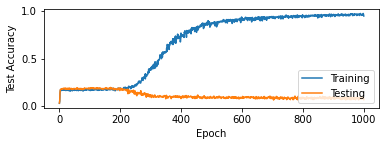

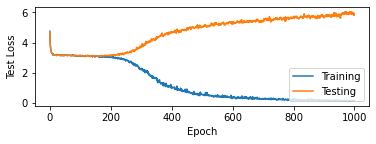

In [110]:
plt.figure(1)

plt.subplot(211)
plt.plot(history_accuracy_train)
plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')

plt.subplot(211)
plt.plot(history_accuracy_test)
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training','Testing'],loc='lower right') 

plt.figure(2)

plt.subplot(212)
plt.plot(history_loss_train)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')

plt.subplot(212)
plt.plot(history_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')

plt.legend(['Training','Testing'],loc='lower right') 

plt.show()

---
# Memory vs Accuracy Processing

In [111]:
mem_lens = []
final_accuracies_train = []
final_accuracies_test = []

In [112]:
mem_lens = np.loadtxt("/home/jovyan/TransformerXL/XL/Mem_Lens.txt", dtype=np.float64)
final_accuracies_train =  np.loadtxt("/home/jovyan/TransformerXL/XL/Final_Accuracies_Train.txt", dtype=np.float64)
final_accuracies_test =  np.loadtxt("/home/jovyan/TransformerXL/XL/Final_Accuracies_Test.txt", dtype=np.float64)

In [113]:
mem_lens = np.append(mem_lens, memory_length)
final_accuracies_train = np.append(final_accuracies_train, accuracy_train)
final_accuracies_test = np.append(final_accuracies_test, accuracy_test)
print(mem_lens)
print(final_accuracies_train)
print(final_accuracies_test)

[ 10.  40.  40. 100.  40.  40.]
[0.927778   1.         1.         1.         1.         0.94875622]
[0.188889   0.091156   0.091156   0.08429    0.108081   0.06936416]


In [114]:
mem_accuracy_train = ({mem_len:accuracy_train for mem_len, accuracy_train in zip(mem_lens, final_accuracies_train)})
mem_accuracy_test = ({mem_len:accuracy_test for mem_len, accuracy_test in zip(mem_lens, final_accuracies_test)})

mem_lens_train_sorted = np.array([l for l in sorted(mem_accuracy_train)])
mem_lens_test_sorted = np.array([l for l in sorted(mem_accuracy_test)])

final_accuracies_train_sorted = np.array([mem_accuracy_train[l] for l in mem_lens_train_sorted])
final_accuracies_test_sorted = np.array([mem_accuracy_test[l] for l in mem_lens_test_sorted])

In [115]:
np.savetxt('/home/jovyan/TransformerXL/XL/Mem_Lens.txt', (mem_lens), fmt='%f', delimiter='\n')
np.savetxt('/home/jovyan/TransformerXL/XL//Final_Accuracies_Train.txt', (final_accuracies_train), fmt='%f', delimiter='\n')
np.savetxt('/home/jovyan/TransformerXL/XL//Final_Accuracies_Test.txt', (final_accuracies_test), fmt='%f', delimiter='\n')

---
# Memory vs Accuracy Plot

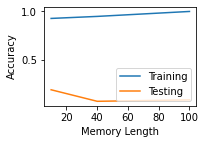

In [116]:
plt.figure(2)
plt.subplot(222)
plt.plot(mem_lens_train_sorted, final_accuracies_train_sorted)
plt.ylabel('Accuracy')

plt.subplot(222)
plt.plot(mem_lens_test_sorted, final_accuracies_test_sorted)
plt.xlabel('Memory Length')

plt.legend(['Training','Testing'],loc='lower right') 

plt.show()

---
# Testing Model

In [117]:
x_train, pre_y_train, post_y_train = batch_train = Full_Batch(batch_size, x_flattened_train, pre_y_flattened_train, post_y_flattened_train, num_chars_data_train, seq_len, rng)
x_test, pre_y_test, post_y_test = Full_Batch(batch_size, x_flattened_test, pre_y_flattened_test, post_y_flattened_test, num_chars_data_test, seq_len, rng)

In [121]:
train = model.predict(x_train)
train = tf.argmax(train, -1)
train = decode_seq(train[0], i_to_c_pandp)
target = decode_seq(post_y_train[0], i_to_c_pandp)
print(train)
print('\n')
print(target)

a brreleo u daredsa  Mh. Bi gvey will es verysuddenly addrelsed her withetake melight in vexing me.tYou have no compassion for my poor nervys."However little  nown the feelings ornviews of such a manm


, surely. I dare say Mr. Bingley will be verysuddenly addressed her with:take delight in vexing me. You have no compassion for my poor nerves."However little known the feelings or views of such a man 


In [122]:
test = model.predict(x_test)
test = tf.argmax(test, -1)
test = decode_seq(test[0], i_to_c_pandp)
target = decode_seq(post_y_test[0], i_to_c_pandp)
print(test)
print('\n')
print(target)

e o yhen  siohedhed . o mehnet ara llehnl nctyoed isnt is n  itfiher hiu tsmictosooes o ou nae thuthheos l t ad oet ytthlt  s.he_rty .egrte thghee i geellet."ihohtto thwthetesonat  i ner ol eor s iori


ver it, and live to see many young men of four"How so? How can it affect them?"not depend on her serving you."told me all about it."of a good fortune, must be in want of a wife.
